In [1]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Morning Session 6: Variational Autoencoders

In this session you will implement a simple variational autoencoder based on the original paper by Kingma and Welling.

The network will be based on a fully connected deep neural network.
The dataset will be the MNIST dataset.
We will use stochastic gradient descent to maximize the ELBO i.e. minimizing the KL-Divergence.

You will have to refer to the notes of the previous day for technical reference.

#### A few imports before we get started

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import random 
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


### Mounting the google drive for later storage

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


### Exercise 1: Implementing the Deep Neural Networks

Variational Autoencoders and Autoencoders more generally are a special type of neural network that take as an input a training example, perform a (non-)linear transformation of that data and outputs a reconstructed version of the input.

The first step of the exercise will be to implement a simple deep neural network for a variational autoencoder.

The general structure will be: _Encoder_ -> _Latent Space_ -> _Decoder_

![](https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png)
_Credit to Lilian Weng and her [blog](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html) on VAE's_

The encoder should consist of 2 hidden layers and a layer for the mean and the log-variance of the latent space variables i.e. you will need at least 4 ```nn.Linear``` layers to implement your encoder. We will use the following number of neurons for each layer:
1. Layer 1: 784->512 neurons
2. Layer 2: 512->256 neurons
3. a) Layer 3 (Mean): 256->Size of Latent Space
3. b) Layer 3 (Log Var): 256-> Size of Latent Space
The decoder should consist of 3 hidden layers with following architecture:

1. Layer 4: Size of Latent Space -> 256 neurons
2. Layer 5: 256 -> 512 neurons
3. Layer6: 512 -> 784 neurons

Use ReLU activation functions for all the layers except the layers representing the mean and log-variance as well as the final output layer of the reconstruction.
No activation is required on the mean and log-var layers - a sigmoid should be used on the final output layer.

Use the available template ```nn.Module``` to implement your networks.

#### Exercise Template

In [122]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # encoder torch.nn layers
        
        # decoder torch.nn layers

        # activations        
        self.activation = False
        self.sigmoid = False
        
    def encoder(self, x):
        # Implement the Encoder
        return mu, logvar
    
    def latent_space(self, mu, log_var):
      # The reparametrization trick in action
        if self.training:
          std = torch.exp(0.5*log_var)
          eps = torch.randn_like(std)
          z = eps.mul(std).add_(mu) 
        else:
          z = mu
        return z
        
    def decoder(self, z):
      # Implement the decoder
        return reconstruction
    
    def forward(self, x):
      #Encode the given image
        mu, log_var = self.encoder(x.view(-1, 784))
        
        # Create the latent-variable representation
        z = self.latent_space(mu, log_var)
        
        # Reconstruct the image from the latent-variables
        reconstruction = self.decoder(z)
        return reconstruction.view(-1, 1, 28, 28), z, mu, log_var

# build model and test it
x = torch.randn((1, 1, 28, 28))
model = VAE()
x_, z, mu, logvar = model(x)
print(x_.size(), z.size(), mu.size(), logvar.size())

NameError: ignored

### Worked Example


In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # encoder
        self.linear1 = nn.Linear(1*28*28, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3_mu = nn.Linear(256, 2)
        self.linear3_logvar = nn.Linear(256, 2)
        # decoder
        self.linear4 = nn.Linear(2, 256)
        self.linear5 = nn.Linear(256, 512)
        self.linear6 = nn.Linear(512, 1*28*28)
        
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encoder(self, x):
        h = self.activation(self.linear1(x))
        h = self.activation(self.linear2(h))
        
        mu = self.linear3_mu(h)
        logvar = self.linear3_logvar(h)
        return mu, logvar
    
    def latent_space(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5*log_var)
            eps = torch.randn_like(std).to(device)
            z = eps.mul(std).add_(mu) 
        else:
            z = mu
        return z
        
    def decoder(self, z):
        h = self.activation(self.linear4(z))
        h = self.activation(self.linear5(h))
        reconstruction = self.sigmoid(self.linear6(h)) 
        return reconstruction
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.latent_space(mu, log_var)
        reconstruction = self.decoder(z)
        return reconstruction.view(-1, 1, 28, 28), z, mu, log_var

# build model
x = torch.randn((1, 1, 28, 28)).to(device)
model = VAE().to(device)
x_, z, mu, logvar = model(x)
print(x_.size(), z.size(), mu.size(), logvar.size())

torch.Size([1, 1, 28, 28]) torch.Size([1, 2]) torch.Size([1, 2]) torch.Size([1, 2])


### Exercise 2: Implement a custom Dataloader for the VAE training

The custom dataset should only take images of the MNIST dataset and output MNIST images, no need to output labels or use transforms.
Remember: The dataset is represented as grayscale values between 0-255. What we want is a representation between 0 and 1.

#### Exercise Template

In [4]:
from torch.utils.data import Dataset 

mnist_train_dset = MNIST("./", download=True, train=True)
mnist_test_dset = MNIST("./", download=True, train=False)

class CustomVAETensorDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
        """


    def __len__(self):
      
        return len(self.data)

    def __getitem__(self, idx):

        return sample

mnist_train = CustomVAETensorDataset(mnist_train_dset.train_data)
mnist_test = CustomVAETensorDataset(mnist_test_dset.test_data)

#### Reference Implementation

In [5]:
mnist_train_dset = MNIST("./", download=True, train=True)
mnist_test_dset = MNIST("./", download=True, train=False)

from torch.utils.data import Dataset 

class CustomVAETensorDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        sample = sample.view(1, 28, 28).float()
        sample /= 255.

        return sample

mnist_train = CustomVAETensorDataset(mnist_train_dset.train_data)
mnist_test = CustomVAETensorDataset(mnist_test_dset.test_data)

Using downloaded and verified file: ./MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw
Using downloaded and verified file: ./MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/Users/distiller/project/conda/conda-bld/pytorch_1587428061935/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/Users/xiexun/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/xiexun/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


### Exercise 3: Implement the VAE loss functions

$$ KLD = -\frac{1}{2}\sum_i^{Latent~Dim}\{ 1+\log \sigma^2_i(x) - \mu_i(x)^2 - e^{\log\sigma^2_i(x)} \}$$
$$ Reconstruction \ Loss = BinaryCrossEntropy(x, x')$$

Don't compute the mean in the BinaryCrossEntropy (size_averge=False) because we are treating each pixel as a random variable!

In [5]:
def kl_divergence(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD
  
def loss_function(recon_x, x, mu, log_var):
    bce_criterion = nn.BCELoss(size_average=False)
    reconstruction_loss = bce_criterion(recon_x, x)
    kld = kl_divergence(mu, log_var)
    return reconstruction_loss, kld

### Provided Train, Validation and Evaluate Functions


In [6]:
def train(model, optimizer, data_loader):
    model.train()
    train_bce, train_kld = 0, 0
    for X in data_loader:
        X = X.to(device)
        optimizer.zero_grad()
        x_, z, mu, logvar = model(X.float())
        bce, kld = loss_function(x_, X.float(), mu, logvar)
        
        total_loss = bce+kld
        total_loss.backward()
        
        train_bce += bce
        train_kld += kld
        
        optimizer.step()  
        
    return train_bce/len(data_loader.dataset), train_kld/len(data_loader.dataset)
  
def validate(model, data_loader):
    model.train()
    validation_bce, validation_kld = 0, 0
    for X in data_loader:
        with torch.no_grad():
            X = X.to(device)
            x_, z, mu, logvar = model(X)
            bce, kld = loss_function(x_, X, mu, logvar)

            total_loss = bce+kld

            validation_bce += bce
            validation_kld += kld
        
    return validation_bce/len(data_loader.dataset), validation_kld/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    xs, zs = [], []
    for X in data_loader:
        with torch.no_grad():
            X = X.to(device)
            x_, z, _, _ = model(X)

            xs.append(x_.cpu().numpy())
            zs.append(z.cpu().numpy())
            
    return np.concatenate(xs, 0),  np.concatenate(zs, 0)

 ### Set the hyperparameters of your model
- Seed: 42
- learning rate: 1e-3
- Optimizer: Adam
- Number of Epochs: 300
- Batchsize: 128
- Test Batch Size (no effect on training apart from time): 1024
- Shuffle the training set every epoch: Yes

In [9]:
seed = 42
lr = 1e-3
batch_size = 128
test_batch_size = 1024
n_epochs = 300

### Instantiate our model, optimizer and loss function
Set the random number generator seed using ```set_seed``` to make everything reproducible.
As a criterion use a sensible loss for the multi-class classification problem.

### Excercise 4: Perform the training of the variational autoencoder
Train your VAE and visualize the reconstruction loss and the KL-Divergence

In [8]:
def train_model():
    #set_seed(42)
    model = VAE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

    min_loss = 1e6-1
    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_kld = train(model, optimizer, train_loader)

        logs['' + 'bce'] = train_loss.item()
        logs['' + 'kld'] = train_kld.item()

        validation_loss, validation_kld = validate(model, test_loader)
        logs['val_' + 'bce'] = validation_loss.item()
        logs['val_' + 'kld'] = validation_kld.item()

        liveloss.update(logs)
        liveloss.draw()

        #Store best validation loss model
        if validation_loss < min_loss:
            torch.save(model.state_dict(), F"/content/gdrive/My Drive/models/mnist_vae_"+str(epoch)+".pth")
            min_loss = validation_loss
      
    return model

model = train_model()

/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


RuntimeError: reduce failed to synchronize: device-side assert triggered

### Exercise 5: Load the best model checkpoint and inspection of results

Perform the following tasks:

1. Load the best model checkpoint based on the validation loss
2. Apply the VAE to the test dataset and store the reconstructions and latent-variables.
3. Plot the first 100 test set images and their reconstructions
4. Plot the 10000 images of the test set in their latent-space representation and use color to highlight the class labels of the MNIST digits.
  - What do you observe?


#### Reference Implementation

In [13]:
model = VAE()
model.load_state_dict(torch.load(F"/content/gdrive/My Drive/models/mnist_vae_260.pth"))
model.eval()

VAE(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3_mu): Linear(in_features=256, out_features=2, bias=True)
  (linear3_logvar): Linear(in_features=256, out_features=2, bias=True)
  (linear4): Linear(in_features=2, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=512, bias=True)
  (linear6): Linear(in_features=512, out_features=784, bias=True)
  (activation): ReLU()
  (sigmoid): Sigmoid()
)

#### Getting Latent Space Representation and Reconstructions

In [14]:
test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)
xs, zs = evaluate(model.to(device), test_loader)
print(xs.shape, zs.shape)

(10000, 1, 28, 28) (10000, 2)


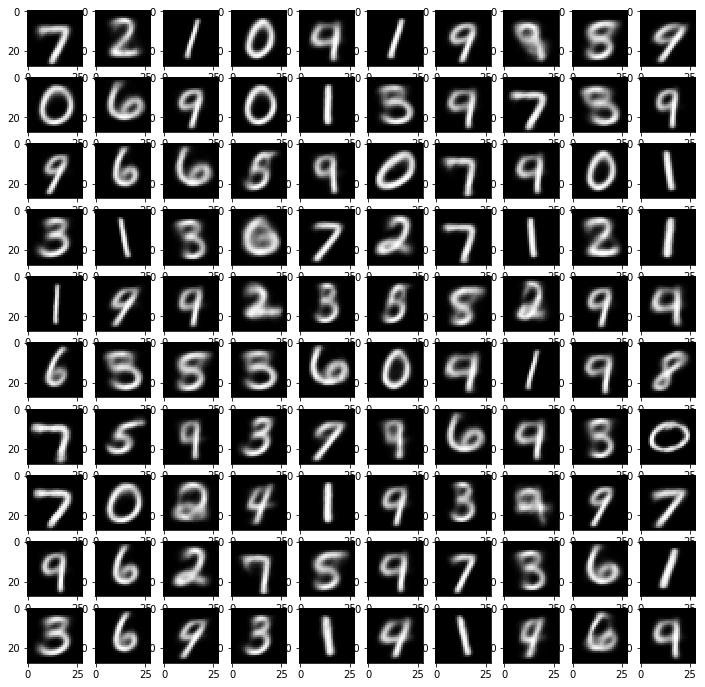

In [15]:
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), xs[0:100, 0]):
    ax.imshow(img, cmap="gray")

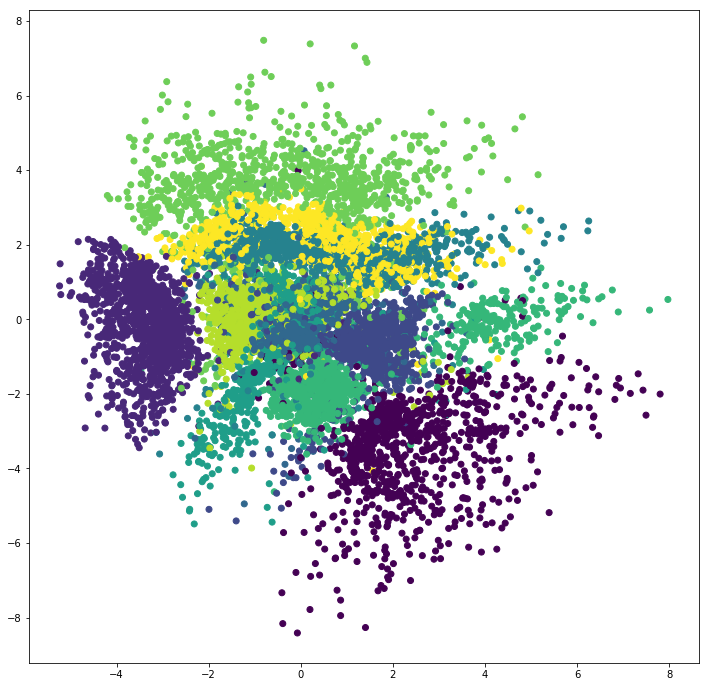

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter(zs[:, 0], zs[:, 1], c=mnist_test_dset.targets)

Wee see that the network has learned an embedding of the MNIST dataset